In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

In [17]:
df = pd.read_csv("/content/xy_data.csv")
x = df['x'].to_numpy()
y = df['y'].to_numpy()

In [18]:
print(x)

[88.364456 74.283936 60.256474 ... 83.44702  63.372417 66.02347 ]


In [1]:
# ===============================================
# Utility Functions
# -----------------------------------------------
# 1. compute_u_v(theta, X, x, y)
#    - Undo translation (X, 42)
#    - Undo rotation by angle 'theta'
#
# 2. intrinsic_model(u, M)
#    - The true underlying functional form:
#        v = exp(M * |u|) * sin(0.3 u)
# ===============================================

In [23]:
def compute_u_v(theta_deg, X, x, y):
    th = np.deg2rad(theta_deg)
    x0, y0 = x - X, y - 42.0
    u =  x0*np.cos(th) + y0*np.sin(th)
    v = -x0*np.sin(th) + y0*np.cos(th)
    return u, v

In [24]:
def intrinsic_model(u, M):
    return np.exp(M*np.abs(u)) * np.sin(0.3*u)

In [2]:
# ===============================================
# Residual Function
# -----------------------------------------------
# Computes:
#   residual = (v_data - intrinsic_model(u, M))
#
# Additionally applies a SOFT constraint:
#   6 <= u <= 60
#
# This keeps the recovered intrinsic parameter
# in the correct range.
# ===============================================

In [29]:
def residuals(params, alpha=5.0):
    th_deg, M, X = params
    u, v = compute_u_v(th_deg, X, x, y)
    v_model = intrinsic_model(u, M)

    r_fit = v - v_model

    # Penalize u < 6 or u > 60
    low  = np.maximum(0, 6 - u)
    high = np.maximum(0, u - 60)
    r_box = alpha * np.hstack([low, high])

    return np.hstack([r_fit, r_box])

In [ ]:
# ===============================================
# Multi-Start Parameter Optimization
# -----------------------------------------------
# Because the problem is nonlinear, we repeat the
# fitting multiple times using different initial
# guesses. Then we take the best solution.
# ===============================================

In [30]:
# Bounds (theta in degrees)
lb = np.array([0.0,    -0.05,  0.0 ])
ub = np.array([50.0,    0.05, 100.0])

In [31]:
# Multi-start to avoid local minima
best = None
best_cost = np.inf
rng = np.random.default_rng(0)
for _ in range(12):
    theta0 = rng.uniform(5, 45)   # θ initial guess
    M0     = rng.uniform(-0.02, 0.02) # M initial guess
    X0     = rng.uniform(5, 95)     # X initial guess
    p0 = np.array([theta0, M0, X0])

    res = least_squares(
        residuals, p0, bounds=(lb, ub),
        loss='soft_l1', f_scale=1.0, max_nfev=2000
    )
    if res.cost < best_cost:
        best_cost = res.cost
        best = res

theta_deg, M_hat, X_hat = best.x
theta_rad = np.deg2rad(theta_deg)
print(f"Estimated parameters:\n  theta = {theta_deg:.6f} deg\n  M = {M_hat:.6f}\n  X = {X_hat:.6f}")

Estimated parameters:
  theta = 29.999973 deg
  M = 0.030000
  X = 54.999998


In [3]:
# ===============================================
# Compute L1 Score
# -----------------------------------------------
# Steps:
# 1. Recover intrinsic u-values
# 2. Sort data by u
# 3. Interpolate "expected curve"
# 4. Generate predicted curve using fitted params
# 5. Compute L1
# ===============================================

In [32]:
# L1 metric
u, v = compute_u_v(theta_deg, X_hat, x, y)

# Sort by recovered u
order = np.argsort(u)
u_sorted = u[order]
x_sorted = x[order]
y_sorted = y[order]

# Expected curve (interpolated)
grid = np.linspace(6, 60, 400)
fx = interp1d(u_sorted, x_sorted, fill_value="extrapolate")
fy = interp1d(u_sorted, y_sorted, fill_value="extrapolate")
x_exp, y_exp = fx(grid), fy(grid)

# Predicted curve
t = grid
x_pred = t*np.cos(theta_rad) - np.exp(M_hat*np.abs(t))*np.sin(0.3*t)*np.sin(theta_rad) + X_hat
y_pred = 42 + t*np.sin(theta_rad) + np.exp(M_hat*np.abs(t))*np.sin(0.3*t)*np.cos(theta_rad)

# L1 metric
L1 = np.mean(np.abs(x_exp - x_pred) + np.abs(y_exp - y_pred))
print("L1 Score =", L1)

L1 Score = 0.00017028009611108174


In [4]:
# ===============================================
# Plot in Intrinsic (u, v) Space
# -----------------------------------------------
# After undoing rotation+translation, the points
# should lie directly on the intrinsic curve:
#        v = exp(M|u|) * sin(0.3u)
# ===============================================

# ===============================================
# Plot in Original (x, y) Space
# -----------------------------------------------
# Shows how well the predicted curve overlaps the
# original dataset. Should align almost perfectly.
# ===============================================

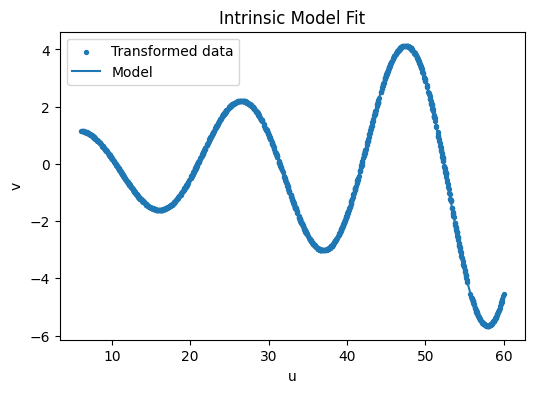

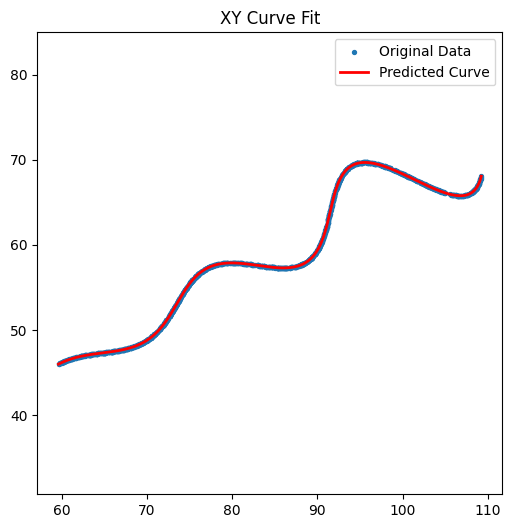

In [33]:
# Intrinsic fit
plt.figure(figsize=(6,4))
plt.scatter(u, v, s=8, label="Transformed data")
U = np.linspace(min(u), max(u), 800)
plt.plot(U, intrinsic_model(U, M_hat), label="Model")
plt.title("Intrinsic Model Fit")
plt.xlabel("u"); plt.ylabel("v")
plt.legend()
plt.show()

# XY curve fit
plt.figure(figsize=(6,6))
plt.scatter(x, y, s=8, label="Original Data")
plt.plot(x_pred, y_pred, 'r', label="Predicted Curve", linewidth=2)
plt.axis("equal")
plt.title("XY Curve Fit")
plt.legend()
plt.show()